In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Read training and validation datasets
train_seq_df = pd.read_csv("datasets/train/train_text_seq.csv")
train_seq_X = train_seq_df['input_str'].tolist()
train_seq_Y = train_seq_df['label'].tolist()

valid_seq_df = pd.read_csv("datasets/valid/valid_text_seq.csv")
valid_seq_X = valid_seq_df['input_str'].tolist()
valid_seq_Y = valid_seq_df['label'].tolist()

# Character-level tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_seq_X)  # Fit only on training data

# Convert sequences to integers
train_sequences = tokenizer.texts_to_sequences(train_seq_X)
valid_sequences = tokenizer.texts_to_sequences(valid_seq_X)

# Get max length from training data
max_len = max(len(seq) for seq in train_sequences)

# Pad sequences
X_train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
X_valid_padded = pad_sequences(valid_sequences, maxlen=max_len, padding='post')

# One-hot encode sequences
vocab_size = len(tokenizer.word_index) + 1
X_train = tf.keras.utils.to_categorical(X_train_padded, num_classes=vocab_size)
X_valid = tf.keras.utils.to_categorical(X_valid_padded, num_classes=vocab_size)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_seq_Y)  # Fit on training labels
y_valid = label_encoder.transform(valid_seq_Y)      # Transform validation labels





In [3]:
import itertools
# Hyperparameter grid
lstm_units = [44]
dropout_rate = [0.3]
batch_size = [32, 64]
learning_rate = [0.001]
epochs = [150]  # You can vary epochs too

# Create all combinations of hyperparameters
hyperparameter_combinations = itertools.product(lstm_units, dropout_rate, batch_size, learning_rate, epochs)

# Initialize variables to track the best model and its validation accuracy
best_val_accuracy = 0
best_params = {}
best_model = None

# Loop over all combinations of hyperparameters
for lstm_units, dropout_rate, batch_size, learning_rate, epochs in hyperparameter_combinations:
    print(f"Training with units={lstm_units}, dropout={dropout_rate}, "
          f"batch_size={batch_size}, learning_rate={learning_rate}, epochs={epochs}")
    
    # Build the model
    model = Sequential([
        LSTM(lstm_units, input_shape=(max_len, vocab_size), recurrent_dropout=0.2),
        Dropout(dropout_rate),
        Dense(len(label_encoder.classes_), activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    model.summary()
    # Add early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train, 
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping],
        verbose=1  # Suppress output for cleaner log
    )
    
    # Get the best validation accuracy for this model
    val_accuracy = max(history.history['val_accuracy'])
    
    # If this model has the best validation accuracy so far, save it
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = {
            'lstm_units': lstm_units,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'epochs': epochs
        }
        best_model = model

# Print the best hyperparameters and validation accuracy
print(f"Best validation accuracy: {best_val_accuracy}")
print(f"Best hyperparameters: {best_params}")

# Evaluate the best model on the validation set
final_val_loss, final_val_accuracy = best_model.evaluate(X_valid, y_valid)
print(f"Final validation accuracy with best hyperparameters: {final_val_accuracy}")

# Optional: Make predictions on validation set
predictions = model.predict(X_valid)
predicted_labels = label_encoder.inverse_transform(predictions.argmax(axis=1))

Training with units=44, dropout=0.3, batch_size=32, learning_rate=0.001, epochs=150


c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 44)             │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,946 (38.85 KB)

 Trainable params: 9,946 (38.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5455 - loss: 0.6889 - val_accuracy: 0.6155 - val_loss: 0.6693
Epoch 2/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5825 - loss: 0.6741 - val_accuracy: 0.5726 - val_loss: 0.6656
Epoch 3/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6056 - loss: 0.6602 - val_accuracy: 0.6278 - val_loss: 0.6386
Epoch 4/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6134 - loss: 0.6575 - val_accuracy: 0.6339 - val_loss: 0.6344
Epoch 5/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6078 - loss: 0.6574 - val_accuracy: 0.6442 - val_loss: 0.6434
Epoch 6/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6351 - loss: 0.6470 - val_accuracy: 0.6442 - val_loss: 0.6281
Epoch 7/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6223 - loss: 0.6459 - val_accuracy: 0.6462 - val_loss: 0.6217
Epoch 8/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6294 - loss: 0.6435 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 44)             │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,946 (38.85 KB)

 Trainable params: 9,946 (38.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5325 - loss: 0.6903 - val_accuracy: 0.5971 - val_loss: 0.6717
Epoch 2/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5801 - loss: 0.6731 - val_accuracy: 0.6237 - val_loss: 0.6607
Epoch 3/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5933 - loss: 0.6679 - val_accuracy: 0.6155 - val_loss: 0.6502
Epoch 4/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5937 - loss: 0.6660 - val_accuracy: 0.6135 - val_loss: 0.6442
Epoch 5/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6024 - loss: 0.6605 - val_accuracy: 0.6339 - val_loss: 0.6412
Epoch 6/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6096 - loss: 0.6517 - val_accuracy: 0.6217 - val_loss: 0.6443
Epoch 7/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6221 - loss: 0.6466 - val_accuracy: 0.6217 - val_loss: 0.6401
Epoch 8/150
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6156 - loss: 0.6502 - 


Training with 20.0% of training data
Epoch 1/150


c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5095 - loss: 0.6951 - val_accuracy: 0.5828 - val_loss: 0.6871 - learning_rate: 0.0010
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5142 - loss: 0.6906 - val_accuracy: 0.5828 - val_loss: 0.6850 - learning_rate: 0.0010
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5504 - loss: 0.6868 - val_accuracy: 0.5624 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5630 - loss: 0.6803 - val_accuracy: 0.6299 - val_loss: 0.6702 - learning_rate: 0.0010
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6107 - loss: 0.6738 - val_accuracy: 0.6155 - val_loss: 0.6707 - learning_rate: 0.0010
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6058 - loss: 0.6685 - val_accuracy: 0.6258 - val_loss: 0.6600 - learning_rate: 0.0010
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6242 - loss: 0.6601 - val_accuracy

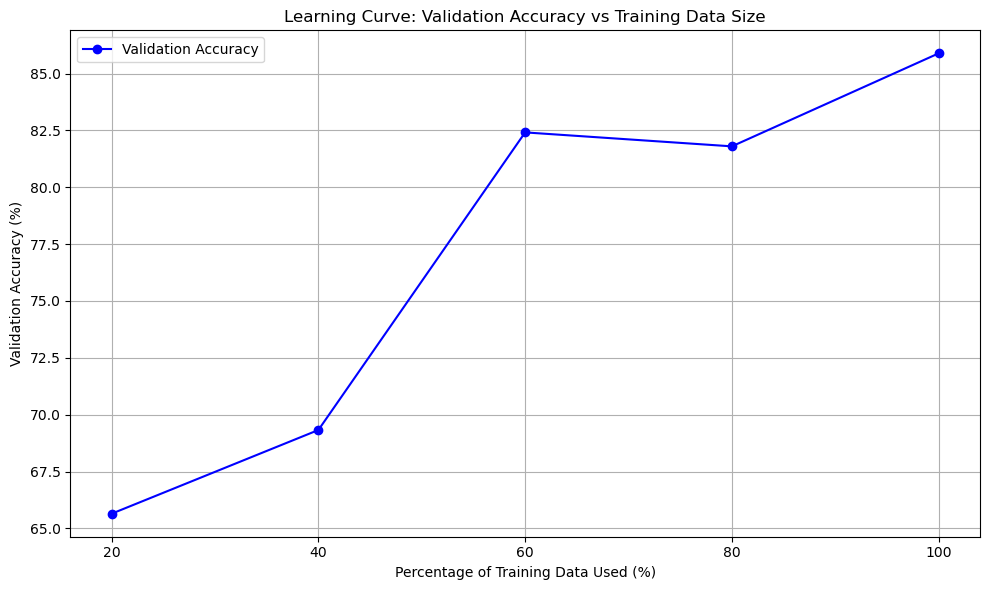

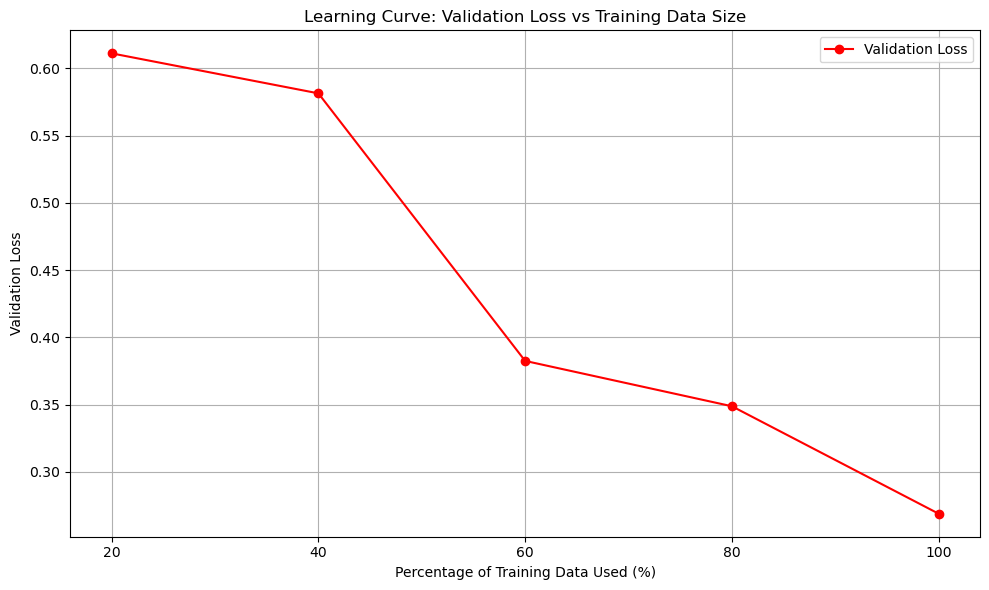


Summary of Results:
Percentage  |  Training Samples  |  Validation Accuracy  |  Validation Loss
----------------------------------------------------------------------
     20.0% |              1416 |             65.64% |          0.6111
     40.0% |              2832 |             69.33% |          0.5814
     60.0% |              4248 |             82.41% |          0.3825
     80.0% |              5664 |             81.80% |          0.3488
    100.0% |              7080 |             85.89% |          0.2689

Results saved to 'training_results.json'


In [4]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import json

# Define the percentages of training data to use
train_percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
results = {
    'percentages': [],
    'train_samples': [],
    'val_accuracy': [],
    'val_loss': []
}

# Function to create and compile model with best parameters
def create_model(input_shape, num_classes, lstm_units, learning_rate):
    model = Sequential()
    model.add(LSTM(
        lstm_units,
        input_shape=input_shape,
        return_sequences=False,
        recurrent_dropout=0.2
    ))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Train model with different percentages of data
for percentage in train_percentages:
    print(f"\nTraining with {percentage*100}% of training data")
    
    # Calculate number of training samples to use
    n_train_samples = int(len(X_train) * percentage)
    
    # Get the subset of training data
    X_train_subset = X_train[:n_train_samples]
    y_train_subset = y_train[:n_train_samples]
    
    # Create and compile model
    model = create_model(
        input_shape=(max_len, vocab_size),
        num_classes=len(label_encoder.classes_),
        lstm_units=best_params['lstm_units'],
        learning_rate=best_params['learning_rate']
    )
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.001,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X_train_subset,
        y_train_subset,
        batch_size=best_params['batch_size'],
        epochs=best_params['epochs'],
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_valid, y_valid, verbose=0)
    
    # Store results
    results['percentages'].append(percentage * 100)
    results['train_samples'].append(n_train_samples)
    results['val_accuracy'].append(val_accuracy)
    results['val_loss'].append(val_loss)
    
    print(f"\nResults for {percentage*100}% of training data:")
    print(f"Number of training samples: {n_train_samples}")
    print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}")

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(results['percentages'], 
         [acc * 100 for acc in results['val_accuracy']], 
         'bo-', 
         label='Validation Accuracy')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Validation Accuracy (%)')
plt.title('Learning Curve: Validation Accuracy vs Training Data Size')
plt.grid(True)
plt.legend()
plt.xticks(results['percentages'])
plt.tight_layout()
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 6))
plt.plot(results['percentages'], 
         results['val_loss'], 
         'ro-', 
         label='Validation Loss')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Validation Loss')
plt.title('Learning Curve: Validation Loss vs Training Data Size')
plt.grid(True)
plt.legend()
plt.xticks(results['percentages'])
plt.tight_layout()
plt.show()

# Print summary table
print("\nSummary of Results:")
print("Percentage  |  Training Samples  |  Validation Accuracy  |  Validation Loss")
print("-" * 70)
for i in range(len(results['percentages'])):
    print(f"{results['percentages'][i]:9.1f}% |  {results['train_samples'][i]:16d} |  {results['val_accuracy'][i]*100:16.2f}% |  {results['val_loss'][i]:14.4f}")

# Save results to a file
with open('training_results.json', 'w') as f:
    json.dump({
        'percentages': results['percentages'],
        'train_samples': results['train_samples'],
        'val_accuracy': [float(acc) for acc in results['val_accuracy']],
        'val_loss': [float(loss) for loss in results['val_loss']]
    }, f, indent=4)

print("\nResults saved to 'training_results.json'")


C:\Users\DELL\AppData\Local\Temp\ipykernel_20300\3281819390.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


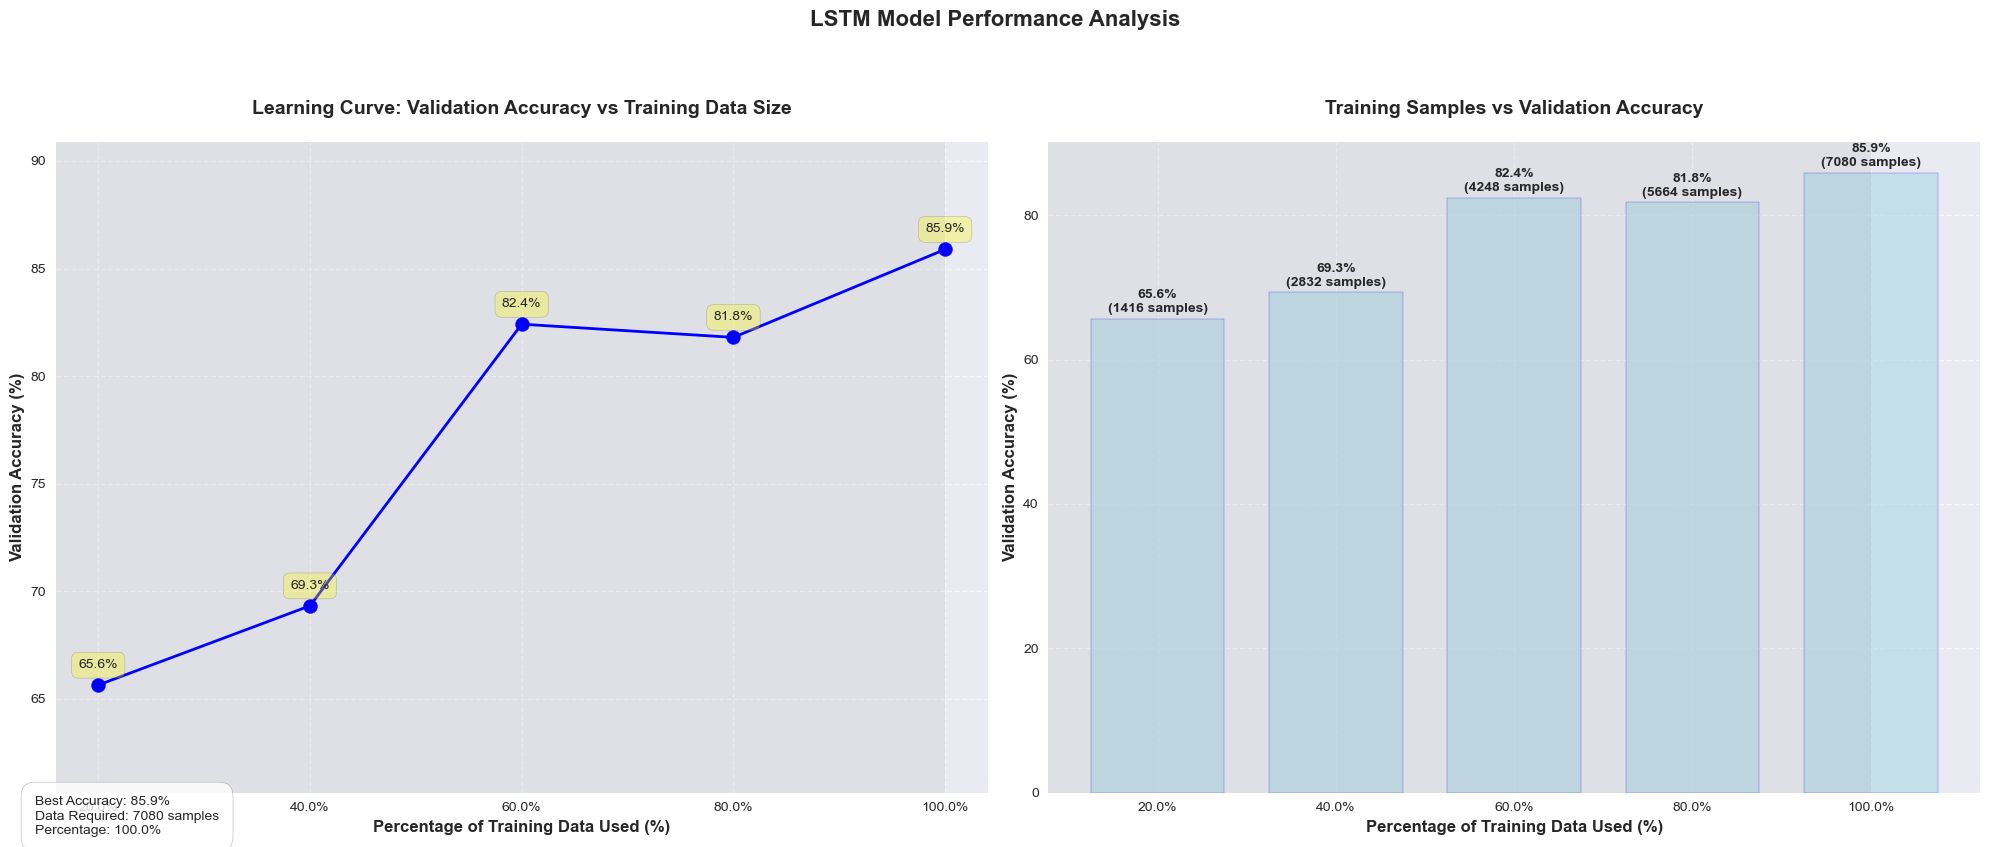


Detailed Performance Summary:
 Percentage  |    Training     |   Validation    |   Validation   
  of Data    |     Samples     |  Accuracy (%)   |      Loss      
--------------------------------------------------------------------------------
    20.0%  |          1416  |         65.64%  |        0.6111
    40.0%  |          2832  |         69.33%  |        0.5814
    60.0%  |          4248  |         82.41%  |        0.3825
    80.0%  |          5664  |         81.80%  |        0.3488
   100.0%  |          7080  |         85.89%  |        0.2689

Results and visualizations have been saved.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

# Assuming 'results' already contains 'percentages', 'val_accuracy', 'val_loss', and 'train_samples'

# Set the style
plt.style.use('seaborn')
sns.set_palette("husl")

# Create figure and axis with larger size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Validation Accuracy
acc_line = ax1.plot(results['percentages'], 
                   [acc * 100 for acc in results['val_accuracy']], 
                   'b-', 
                   linewidth=2,
                   label='Validation Accuracy')

# Add points with annotations
for i, txt in enumerate(results['val_accuracy']):
    acc_percentage = txt * 100
    ax1.scatter(results['percentages'][i], acc_percentage, 
                color='blue', s=100, zorder=5)
    ax1.annotate(f'{acc_percentage:.1f}%', 
                 (results['percentages'][i], acc_percentage),
                 xytext=(0, 10), 
                 textcoords='offset points',
                 ha='center',
                 va='bottom',
                 fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', 
                          fc='yellow', 
                          alpha=0.3))

# Customize first plot
ax1.set_xlabel('Percentage of Training Data Used (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Learning Curve: Validation Accuracy vs Training Data Size', 
              fontsize=14, 
              fontweight='bold', 
              pad=20)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xticks(results['percentages'])
ax1.set_xticklabels([f'{x}%' for x in results['percentages']], fontsize=10)
ax1.set_ylim(min([acc * 100 for acc in results['val_accuracy']]) - 5, 
             max([acc * 100 for acc in results['val_accuracy']]) + 5)

# Add light background shading
ax1.add_patch(Rectangle((0, 0), 100, 100,
                       fill=True,
                       alpha=0.1,
                       color='gray'))

# Plot 2: Training Samples vs Accuracy
ax2.bar(results['percentages'], 
        [acc * 100 for acc in results['val_accuracy']],
        alpha=0.6,
        color='lightblue',
        edgecolor='blue',
        width=15)

# Add value labels on bars
for i, v in enumerate([acc * 100 for acc in results['val_accuracy']]):
    ax2.text(results['percentages'][i], v + 0.5, 
             f'{v:.1f}%\n({results["train_samples"][i]} samples)',
             ha='center', 
             va='bottom',
             fontsize=10,
             fontweight='bold')

# Customize second plot
ax2.set_xlabel('Percentage of Training Data Used (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Training Samples vs Validation Accuracy', 
              fontsize=14, 
              fontweight='bold', 
              pad=20)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xticks(results['percentages'])
ax2.set_xticklabels([f'{x}%' for x in results['percentages']], fontsize=10)

# Add light background shading
ax2.add_patch(Rectangle((0, 0), 100, 100,
                       fill=True,
                       alpha=0.1,
                       color='gray'))

# General styling
plt.suptitle('LSTM Model Performance Analysis', 
             fontsize=16, 
             fontweight='bold',
             y=1.05)

# Add a text box with summary statistics
stats_text = (f'Best Accuracy: {max(results["val_accuracy"])*100:.1f}%\n'
              f'Data Required: {results["train_samples"][np.argmax(results["val_accuracy"])]} samples\n'
              f'Percentage: {results["percentages"][np.argmax(results["val_accuracy"])]}%')
              
fig.text(0.02, 0.02, stats_text,
         fontsize=10,
         bbox=dict(facecolor='white', 
                  alpha=0.8, 
                  edgecolor='gray',
                  boxstyle='round,pad=1'))

plt.tight_layout()

# Save the plot with high DPI
plt.savefig('learning_curve_analysis_d3.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

# Print detailed summary table with formatting
print("\nDetailed Performance Summary:")
print("=" * 80)
print(f"{'Percentage':^12} | {'Training':^15} | {'Validation':^15} | {'Validation':^15}")
print(f"{'of Data':^12} | {'Samples':^15} | {'Accuracy (%)':^15} | {'Loss':^15}")
print("-" * 80)
for i in range(len(results['percentages'])):
    print(f"{results['percentages'][i]:>8.1f}%  | "
          f"{results['train_samples'][i]:>13d}  | "
          f"{results['val_accuracy'][i]*100:>13.2f}%  | "
          f"{results['val_loss'][i]:>13.4f}")
print("=" * 80)

# Save results to a formatted JSON file
import json
with open('training_results_d3.json', 'w') as f:
    json.dump({
        'experiment_summary': {
            'best_accuracy': f"{max(results['val_accuracy'])*100:.1f}%",
            'best_accuracy_samples': results['train_samples'][np.argmax(results['val_accuracy'])],
            'best_accuracy_percentage': f"{results['percentages'][np.argmax(results['val_accuracy'])]}%"
        },
        'detailed_results': {
            'percentages': results['percentages'],
            'train_samples': results['train_samples'],
            'val_accuracy': [float(acc) for acc in results['val_accuracy']],
            'val_loss': [float(loss) for loss in results['val_loss']]
        }
    }, f, indent=4)

print("\nResults and visualizations have been saved.")


In [7]:
# Load test data
test_seq = pd.read_csv("datasets/test/test_text_seq.csv")  # Adjust path as needed
test_seq_X = test_seq['input_str'].tolist()  # Adjust column name as needed

# Process test data using same steps as training
test_sequences = tokenizer.texts_to_sequences(test_seq_X)
X_test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')
X_test = tf.keras.utils.to_categorical(X_test_padded, num_classes=vocab_size)

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Save predictions to text file
with open('pred_textseq.txt', 'w') as f:
    for pred in predicted_classes:
        f.write(f"{pred}\n")

# Print summary statistics
print("\nPredictions saved to pred_sequence.txt")
print(f"Total predictions generated: {len(predicted_classes)}")
print("\nFirst few test sequences and their predictions:")
for i in range(min(5, len(test_seq_X))):
    print(f"Sequence: {test_seq_X[i]}")
    print(f"Prediction: {predicted_classes[i]}")
    print(f"Confidence: {np.max(predictions[i]):.4f}")
    print()

# Print prediction distribution
unique, counts = np.unique(predicted_classes, return_counts=True)
print("\nPrediction distribution:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} instances ({count/len(predicted_classes)*100:.2f}%)")

# Optional: Save detailed predictions with confidence scores
detailed_results = pd.DataFrame({
    'sequence': test_seq_X,
    'predicted_label': predicted_classes,
    'confidence': np.max(predictions, axis=1)
})
detailed_results.to_csv('sequence_predictions_detailed.csv', index=False)
print("\nDetailed predictions saved to 'sequence_predictions_detailed.csv'")

# Print confidence statistics
confidence_scores = np.max(predictions, axis=1)
print("\nConfidence Statistics:")
print(f"Mean confidence: {np.mean(confidence_scores):.4f}")
print(f"Min confidence: {np.min(confidence_scores):.4f}")
print(f"Max confidence: {np.max(confidence_scores):.4f}")
print(f"Median confidence: {np.median(confidence_scores):.4f}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Predictions saved to pred_sequence.txt
Total predictions generated: 2232

First few test sequences and their predictions:
Sequence: 00046461415962624223376356071543628426253321596614
Prediction: 1
Confidence: 0.9997

Sequence: 00061464204642825115436262422159628461433241596262
Prediction: 1
Confidence: 0.9932

Sequence: 00030699262154364226146420159646426215965892284614
Prediction: 1
Confidence: 0.6100

Sequence: 00003695614159615436262464852642226215964089284614
Prediction: 0
Confidence: 0.9886

Sequence: 00014738464484615436159626261442226253326142841596
Prediction: 1
Confidence: 0.9963


Prediction distribution:
Label 0: 1000 instances (44.80%)
Label 1: 1232 instances (55.20%)

Detailed predictions saved to 'sequence_predictions_detailed.csv'

Confidence Statistics:
Mean confidence: 0.8496
Min confidence: 0.5009
Max confidence: 0.9999
Median confidence: 0.9075
